# Modeling the Appearance of West Nile Virus in Chicago

The city of Chicago is looking for ways to optimize its mosquito spraying procedures. Our task is to predict when and where mosquitos are most likely to carry the West Nile Virus.

#### Datasets
- train.csv: Data from every mosquito trap measurement during years 2007, 2009, 2011, 2013
- weather.csv: Daily weather patterns for the city of Chicago

#### Preprocessing
Preparing the data for analysis involved merging the two datasets. We employed a novel method to do this, calculating the distance between each trap and one of two weather stations identified in the weather dataset and then assigning a station number to each trap observation. This method also allowed us to better pinpoint the weather affecting each trap location.

We also conducted a principal component analysis to consolidate the many weather variables we were given, generating five principal components on which to build models.

#### Model Building and Evaluation
We employed two separate strategies in building models to predict the presence of West Nile Virus. The first strategy involved feature selection with SelectKBest and then performing a Random Forest Classifier. The second strategy involved conducting a cluster analysis to generate new features and then performing PCA on the weather data. These steps were followed by a logistic regression model. 

To facilitate running multiple models, we developed a function that could generate the classification metrics we needed to evaluate each model.

In [61]:
# import all libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import binarize
from sklearn.grid_search import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define a random state and train test split % to use throughout
rs = 8
tts = .2

In [62]:
# define functions for classification model evaluation
def doClassifMetrics(y_test, y_pred):
    print 'Confusion Matrix \n', confusion_matrix(y_test, y_pred)
    print 'Classification Report \n', classification_report(y_test, y_pred)

def modelEval(name, model, X, y, binarize_threshold):
    X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2,
        stratify = y, random_state = rs)
    meancvscore = cross_val_score(model, X, y, n_jobs=-1, verbose=1).mean()
    print 'Model %s cross_val_score: %f' % (name, meancvscore)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # this uses default 50% probability threshold to predict 1
    y_pred_adj = binarize(model.predict_proba(X_test)[:,1],
        threshold = binarize_threshold, copy=False).transpose()
    print 'Model %s classification metrics:' % name
    doClassifMetrics(y_test, y_pred)
    print 'Model %s using prediction threshold %f:' % (name, binarize_threshold)
    doClassifMetrics(y_test, y_pred_adj)

In [69]:
# read in cleaned and merged data
df = pd.read_csv('Assets/merged.csv')

## Visualizations

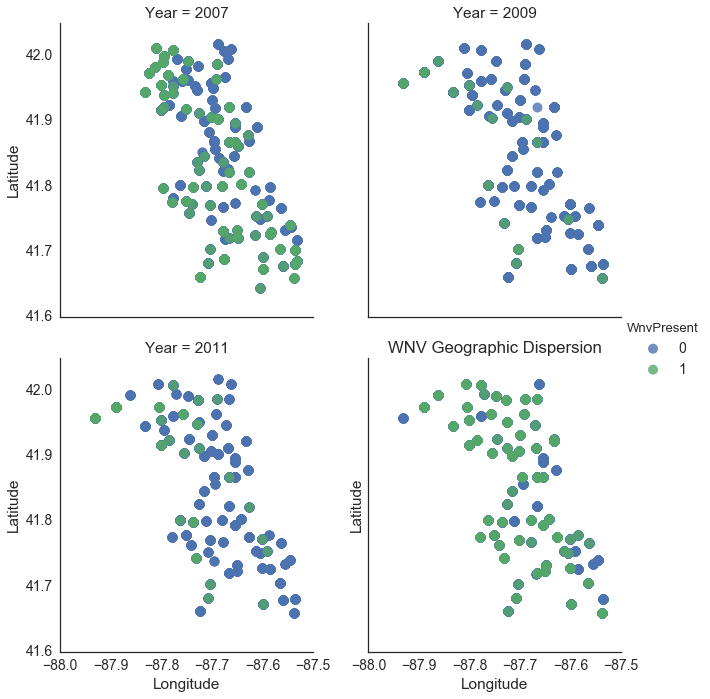

In [64]:
sns.set_context("notebook", font_scale=1.4)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude',
           data=df, 
           fit_reg=False, aspect = .9, col_wrap=2,
           hue="WnvPresent", col='Year', legend_out=True, scatter_kws={"marker": "D", "s": 100})
plt.title('WNV Geographic Dispersion')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

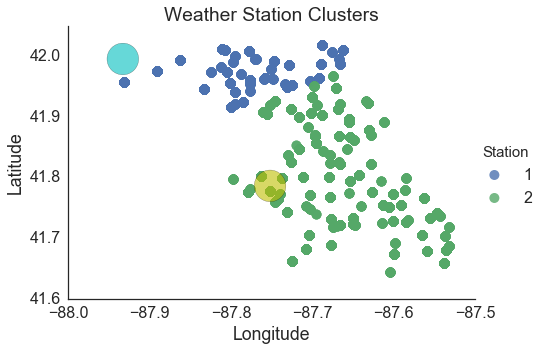

In [65]:
sns.set_context("notebook", font_scale=1.6)
sns.set_style("white")
sns.lmplot('Longitude', 'Latitude', data=df, fit_reg=False, hue="Station", aspect=1.4,
           scatter_kws={"marker": "D", "s": 100})
plt.title('Weather Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
area = 1000
colors = ['c','y']
plt.scatter([-87.933, -87.752], [41.995,41.786], 
            s=area, c = colors, marker='o', alpha=.6)
plt.figure(figsize=(12, 10))

In [70]:
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

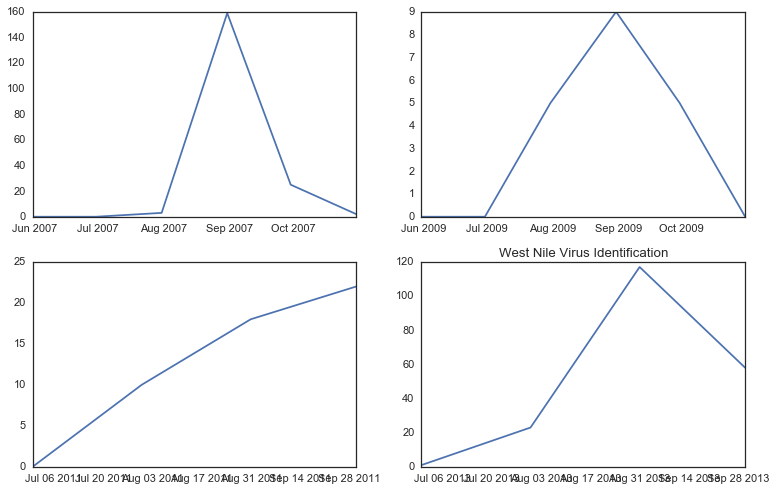

In [76]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
ax0, ax1, ax2, ax3 = axes.flat

ax0.plot(df['2007'][['WnvPresent']].resample('M').apply(sum))
ax1.plot(df['2009'][['WnvPresent']].resample('M').apply(sum))
ax2.plot(df['2011'][['WnvPresent']].resample('M').apply(sum))
ax3.plot(df['2013'][['WnvPresent']].resample('M').apply(sum))

plt.title('West Nile Virus Identification')
plt.tight_layout()

## Approach 1: Select 10 Best Features and use Random Forest Classifier

## Approach 2: Perform Clustering, PCA and use Logistic Regression

#### Perform DBScan

In [32]:
from sklearn.cluster import DBSCAN
# Choose features to cluster
cols_for_cluster = ['NumMosquitos', 'Month', 'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS', 
                   'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 
                    'Tavg', 'PrecipTotal', 'Tmax', 'Tmin', 'DewPoint', 'prev_day_precip']
df_cluster = df[cols_for_cluster]
# Instantiate and fit cluster model
db = DBSCAN(eps=1, min_samples=40)
db.fit(df_cluster)
# Attach cluster labels to feature dataframe
df['cluster'] = db.labels_

Plot clusters

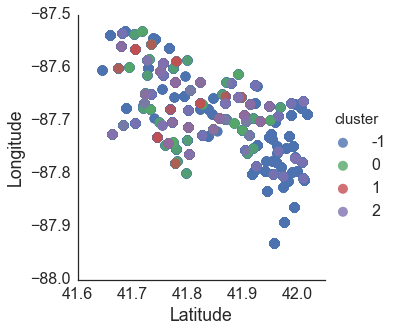

In [47]:
sns.lmplot('Latitude', 'Longitude', data=df, hue='cluster', fit_reg=False,
          scatter_kws={"marker": "D", "s": 100})

#### Conduct PCA

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
# Choose columns for PCA - mostly weather data
cols_for_pca = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 
                'PrecipTotal', 'ResultSpeed', 'AvgSpeed', 'ResultDir', 'StnPressure',
               'prev_day_precip']
X = df[cols_for_pca]
# Standardize
xStd = StandardScaler().fit_transform(X)
# Create covariance matrix, extract eigen pairings
covMat = np.cov(xStd.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)
totalEigen = sum(eigenValues)
# Compute cumulative explained variance
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cvarex = np.cumsum(varExpl)
print cvarex

[  48.15051028   65.45345693   75.73569346   83.16518344   89.26382919
   93.18317375   96.82856801   98.47721881   99.33231682   99.94604807
   99.99197627  100.          100.        ]


90% of the variance is explained by the first five components.

In [54]:
pcask = PCA(n_components=5)
Y = pcask.fit_transform(xStd)
Ydf = pd.DataFrame(Y)

### Logistic Regression

In [83]:
# Use PCA dataframe and add additional features
Ydf['Latitude'] = df.Latitude.values
Ydf['Longitude'] = df.Longitude.values
Ydf['NumMosquitos'] = df.NumMosquitos.values
Ydf['erraticus'] = df['Species_CULEX ERRATICUS'].values
Ydf['pipiens'] = df['Species_CULEX PIPIENS'].values
Ydf['pip_rest'] = df['Species_CULEX PIPIENS/RESTUANS'].values
Ydf['restuans'] = df['Species_CULEX RESTUANS'].values
Ydf['salinarius'] = df['Species_CULEX SALINARIUS'].values
Ydf['tarsalis'] = df['Species_CULEX TARSALIS'].values
Ydf['territans'] = df['Species_CULEX TERRITANS'].values
Ydf['month'] = df.Month.values
Ydf['cluster'] = db.labels_
Ydf['pre_day_precip'] = df.prev_day_precip.values

In [89]:
X = Ydf
y = df.WnvPresent

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from sklearn import metrics
logreg = LogisticRegression()
pred_class = cross_val_predict(logreg, X, y)

In [103]:
print metrics.confusion_matrix(y, pred_class)
print "Recall: ", metrics.recall_score(y, pred_class)
print "Precision: ", metrics.precision_score(y, pred_class)

[[7998   20]
 [ 432   25]]
Recall:  0.054704595186
Precision:  0.555555555556


Optimizing for recall

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, stratify = y)
logreg.fit(X_train, y_train)
y_prob = logreg.predict_proba(X_test)[:,1]
y_pred_class = binarize(y_prob, 0.2)[0]
print "Recall: ", metrics.recall_score(y_test, y_pred_class)
print "Precision: ", metrics.precision_score(y_test, y_pred_class)

Recall:  0.105263157895
Precision:  0.444444444444


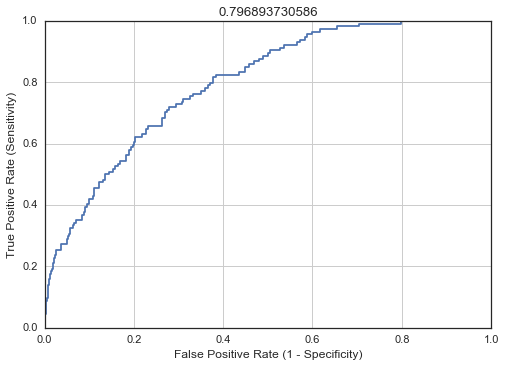

In [112]:
auc_log = metrics.roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title(auc_log)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)